# Training the Mahalanobis distance-based classifier using the developmental brain meta-atlas
In this script, I trained the Mahalanobis distance-based classifier and saved the model to disk. Then, I computed the "important genes" for the classification. This allows the model to be utilized for testing in `Mahalanobis_testing.ipynb`. I also generated **Figure 15** of the report.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

from scipy.spatial.distance import mahalanobis
import scipy.sparse as sp
import numpy.linalg as linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.decomposition import PCA
import joblib
import functools
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### I imported the training dataset and created a duplicate variable. The first variable, `train`, will be used for feature selection, while the second, `trainraw`, will be designated for actual training. This dataset was generated in the notebook titled `fron_no_adolescence_to_final_training_dataset.ipynb`.

In [3]:
train = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations_Interneurons.h5ad')
trainraw = train.copy()

In [4]:
test = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/data/GBM_Tumor_Dissociation.h5ad')

## Step 1: Initial adjustments.

#### I changed the index of `test.var` from ensemble IDs to gene names.

In [5]:
test.var = (
    test.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['marker-DsRed', 'marker-Cherry', 'marker-GFP', 'marker-Tomato', 'marker-cre']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


#### I made unique test names.

In [6]:
test.var.index = test.var.index.astype(str)
test.var_names_make_unique(join="_")

#### I randomly selected 5000 cells for cell class to ensure a more balanced representation across all classes.
**Note**: probably not useful in this classification method. I didn't run it in the last round.

## Step 2: Feature selection.

#### I removed cell cycling genes.

In [7]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/ccGenesHuman.txt', dtype=str)
train = train[:, ~np.isin(train.var_names, ccGenesHuman)]

In [8]:
cc2 = ['CCND2', 'TFDP2']
train = train[:, ~np.isin(train.var_names, cc2)]

#### I excluded mitochondrial, ribosomal, and tubulin genes, as well as MALAT1 and EGFR from the analysis because their overexpression in tumors could bias the classification results.

In [9]:
badGenes = [el for el in train.var_names 
            if el.startswith(('MT-', 'RP', 'TUB')) or el in {'MALAT1', 'EGFR'}]

train = train[:, ~np.isin(train.var_names, badGenes)]

#### I retained only the genes that are common to both the training and test datasets.

In [10]:
commonGenes = np.intersect1d(train.var_names, test.var_names)
train, test, trainraw = [ds[:, commonGenes] for ds in (train, test, trainraw)]

#### I normalized and logarithmized the dataset.

In [11]:
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:27)


#### I selected only the first 4000 most variable genes.

In [12]:
sc.pp.highly_variable_genes(train, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=4000)
train = train[:, train.var.highly_variable]

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


#### I conducted a differential expression analysis followed by a filtering step to identify the most significant genes.


In [13]:
sc.tl.rank_genes_groups(train, groupby="ThirdManualAnnotations",method= 'logreg', use_raw=False)
sc.tl.filter_rank_genes_groups(train,  max_out_group_fraction=0.2)

ranking genes


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:01:08)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1, max_out_group_fraction: 0.2


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### I identified the 25 most expressed and specific genes for each class, excluding NaN values.

In [14]:
filtered_genes = {}
for group in train.uns['rank_genes_groups_filtered']['names'].dtype.names:
    genes = train.uns['rank_genes_groups_filtered']['names'][group]
    filtered_gene_list = [gene for gene in genes if pd.notnull(gene)]
    filtered_genes[group] = filtered_gene_list[:25]
filtered_genes = list(set([item for sublist in filtered_genes.values() for item in sublist]))

#### I imported some manually selected genes.

In [15]:
aleGenes = ['AQP4','ADGRV1','MGST1','SPARCL1','EGFR','ID3','CST3','BCAN', 'VEGFA','LGALS1','LGALS3', 'ETV1','PTPRZ1','ITM2C','HOPX','VIM','CLU', 
            'CDK4','SOX2','STMN1','STMN2', 'ASCL1','HES1','NHLH1','NRXN3','RBP1', 'PLP1', 'OLIG1','OLIG2','SOX10','PDGFRA', 'ACTA2','FN1','CLDN5',
            'VXN','VWF','ITM2A', 'COL1A1','COL3A1','COL4A1', 'IGHM','IGKC', 'CD3G','CD3D','CD3E','TRAC', 'CD4', 'CD8A','GZMH','GZMK','GNLY','CD74',
            'FTL','SPP1','C1QA','C1QB','C1QC','CSF1R', 'HLA-DRA','HLA-DQB1','FOXM1','TYMS']

In [16]:
myGenes = [
    'LIX1', 'LEF1', 'HEY1', 'CRABP2', 'AMBN', 'TPD52L1', 'SNCG', 'ECEL1', 'CNFN', 'OLFM3',
    'CST3', 'TC', 'ATP1A2', 'SPARCL1', 'APOE', 'NEAT1', 'AQP4', 'SLC4A4', 'GLIS3', 'GRM3',
    'TNC', 'MGAT4C', 'LRIG1', 'GJA1', 'ACSL6', 'NPNT', 'PAQR8', 'COL5A3', 'FRMPD2',
    'CD44', 'GALNT15', 'CD38', 'DAAM2', 'ANGPT1', 'COLEC12', 'AQP1', 'HSPB8',
    'PCDH15', 'OPCML', 'CSMD3', 'CA10', 'FGF14', 'NXPH1', 'TNR', 'FGF12', 'MDGA2',
    'DNM3', 'CNTNAP5', 'NRXN3', 'SGCZ', 'COL20A1', 'CHRM3', 'PDGFRA', 'AFAP1L2', 'APOD',
    'PDGFD', 'LIPG', 'IQGAP2', 'AKAP12', 'NIPY', 'TMTC1', 'FBXO32', 'EVA1C', 'LAMA3',
    'CCDC175', 'ELAVL2', 'SRRM4', 'HES6', 'PLXNA2', 'EOMES', 'EPHA3', 'NHLH1', 'GADD45G',
    'MYT1L', 'RBFOX3', 'ELAVL4', 'SLC22A23', 'PGP13', 'KCNB2', 'NEUROG1', 'MFNG',
    'MYCL', 'RGS16', 'CREG2', 'GREM2', 'EBF2', 'NHLH2', 'LHX9', 'SPINK5', 'FNDC5',
    'EBF1', 'NRN1', 'CLMP', 'SLA', 'PPP1R17', 'SL17A6', 'NEUROD2', 'NEUROD6',
    'LGR6', 'VAV3', 'ADCY1', 'RGS6', 'KLHL4', 'GAD1', 'ATP2C2', 'GALR1', 'DBX2',
    'SLC6A11', 'ST8SIA5', 'CCDC80', 'MATN2', 'CAPS2',
    'DLL3', 'ASCL1', 'CCDC178', 'GSG1L', 'RFTN1', 'IGSF9B', 'ANGEL1', 'CASP9',
    'KIRREL3', 'DPF3', 'SLIT1', 'IRX1', 'VIPR2', 'DLX6', 'DLX6-AS1', 'DLX5', 'GAD1', 'GAD2', 'GAD45G', 'EGR1'
]


#### I combined the genes filtered through differential expression analysis with those manually selected.

In [17]:
selectedGenes = np.unique(np.concatenate((aleGenes, filtered_genes, myGenes)))

In [18]:
selectedGenes = functools.reduce(np.intersect1d, (selectedGenes, trainraw.var_names, test.var_names))
trainraw = trainraw[:, selectedGenes]

#### I archived the selected genes for use in the `Mahalanobis_testing.ipynb` notebook.

In [19]:
np.savetxt('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/MD_selected_genes.txt', selectedGenes, delimiter=",", fmt='%s')

## Step 3: training of the model on `trainraw`.

#### Normalization by row and logarithmization.

In [20]:
sc.pp.normalize_total(trainraw, target_sum=1e4)
sc.pp.log1p(trainraw)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


#### I scaled (by column) the training dataset.

In [21]:
train_X_dense = trainraw.X.toarray()
scaler = StandardScaler(with_mean=True, with_std=True)
train_scaled = scaler.fit_transform(train_X_dense)

#### I applied a PCA model to the training dataset.

In [22]:
pca = PCA(n_components=50, svd_solver='auto', random_state=42)

train_pca = pca.fit_transform(train_scaled)
trainraw.obsm['X_pca'] = train_pca

#### I computed means and covariances of each cell class in the pca training subspace.

In [23]:
pca_projections = trainraw.obsm['X_pca']
cell_types = trainraw.obs['ThirdManualAnnotations'].unique()

means = {}
covariances = {}

for cell_type in cell_types:
    subset_indices = trainraw.obs['ThirdManualAnnotations'] == cell_type
    subset_pca = pca_projections[subset_indices]
   
    mean_vector = np.mean(subset_pca, axis=0)
    covariance_matrix = np.cov(subset_pca, rowvar=False)
    means[cell_type] = mean_vector
    covariances[cell_type] = covariance_matrix

#### I saved the scaler and PCA models, along with the means and covariance matrices, to disk so they can be applied to the test dataset in the `Mahalanobis_testing.ipynb` notebook.

In [24]:
joblib.dump(scaler, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/MD_scaler.joblib')
joblib.dump(pca, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/MD_pca.joblib')
joblib.dump(means, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/MD_means.joblib')
joblib.dump(covariances, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/MD_covariances.joblib')

['/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/MD_covariances.joblib']

## Step 4: extracting important genes for the classifier.

The code first computes the pooled covariance matrix from PCA projections of all cells and calculates the mean PCA vector for each cell type. Then, it uses the inverse covariance matrix to derive discriminant vectors in PCA space, maps these vectors back to gene space using the PCA loadings, and finally selects the top 25 genes per cell type based on the highest absolute weights, highlighting the genes that best differentiate each cell type.

In [25]:
#### step 1: compute the pooled covariance matrix in PCA space

# retrieve the PCA projections for all cells from the dataset
pca_projections = trainraw.obsm['X_pca']

# compute the covariance matrix of the PCA projections
# this covariance matrix represents the overall variability in the PCA space,
# using all cells regardless of their type
covariance_pca = np.cov(pca_projections, rowvar=False)

# calculate the pseudo-inverse of the covariance matrix
# the inverse will later be used to compute the discriminant vectors
inv_covariance_pca = linalg.pinv(covariance_pca)


#### step 2: compute the mean vector for each cell type in PCA space
# identify all unique cell types in the dataset
cell_types = trainraw.obs['ThirdManualAnnotations'].unique()
means_pca = {}

for cell_type in cell_types:
    # select the indices corresponding to the current cell type
    indices = trainraw.obs['ThirdManualAnnotations'] == cell_type
    # retrieve the PCA data for these cells
    data_pca = pca_projections[indices]
    # compute the mean vector of the PCA components for these cells,
    # which represents the "center" of the cell type in PCA space
    means_pca[cell_type] = np.mean(data_pca, axis=0)


# step 3: compute the discriminant vectors using the pooled covariance matrix
# for each cell type, scale its mean vector by multiplying it with the pseudo-inverse
# of the covariance matrix. This operation, similar to Fisher's linear discriminant analysis,
# gives a vector that best separates the cell type from others in the PCA space.
discriminant_vectors_pca = {}

for cell_type in cell_types:
    mean_c = means_pca[cell_type]
    w_c_pca = inv_covariance_pca @ mean_c
    discriminant_vectors_pca[cell_type] = w_c_pca


# step 4: map the discriminant vectors back to gene space
# the PCA components tell us how each gene contributes to the principal components.
# To interpret the discriminant vectors in terms of genes, we multiply them by the transpose
# of the PCA components. This gives us a weighted contribution of each gene in the discriminant vector.
pca_components = pca.components_
genes = trainraw.var_names

discriminant_vectors_gene = {}

for cell_type in cell_types:
    w_c_pca = discriminant_vectors_pca[cell_type]
    # map the discriminant vector from PCA space back to gene space
    w_c_gene = pca_components.T @ w_c_pca
    discriminant_vectors_gene[cell_type] = w_c_gene


# step 5: identify the top genes for each cell type
# for each cell type, select the genes with the highest absolute values in the discriminant vector.
# these genes are the most influential in differentiating that cell type from the others.
top_genes_per_class = {}
n_top_genes = 25

# (I created this dictionary to store the genes for the subsequent plot)
top_five_genes = {}

for cell_type in cell_types:
    w_c_gene = discriminant_vectors_gene[cell_type]
    # get indices of the top genes by sorting based on the absolute values of their scores
    top_gene_indices = np.argsort(-np.abs(w_c_gene))[:n_top_genes]
    top_genes = genes[top_gene_indices]
    top_scores = w_c_gene[top_gene_indices]
    top_five_genes[cell_type] = top_genes[0:5]
    # create a DataFrame for the current cell type showing the top genes and their scores
    top_genes_per_class[cell_type] = pd.DataFrame({
        'Gene': top_genes,
        'Score': top_scores
    })
    print(f"\n{cell_type}:")
    print(top_genes_per_class[cell_type])



Subcortical nIPCs:
        Gene     Score
0        SP9  0.575414
1     PDZRN4  0.343861
2       DLX5  0.337525
3       DLX2  0.328017
4       GAD2  0.322531
5       CHGB  0.300004
6       ZIC1  0.289016
7       EBF1  0.276293
8     CDKN2D  0.275700
9      GREM2  0.271016
10      DLX6  0.270927
11  DLX6-AS1  0.253326
12    SORCS2  0.249188
13   CACNA1E  0.244959
14     RAB3C  0.243877
15     EOMES -0.211332
16     NHLH2  0.206585
17      EBF2 -0.204197
18    SPINK5 -0.203041
19     CREG2 -0.198883
20    PDZRN3  0.194731
21    ATP8A2  0.188914
22    PTPRZ1 -0.183335
23     STMN2  0.170424
24   SLC17A6  0.162809

early Radial Glia:
          Gene     Score
0         LIX1  0.149610
1         LEF1  0.126260
2        NDST4  0.123054
3         HEY1  0.110860
4         AMBN  0.109818
5          NPY -0.107917
6         SOX3  0.097001
7       LGALS3 -0.094249
8         HOPX -0.086323
9         SOX2  0.086203
10       EPHA6  0.085096
11     ADAMTS9  0.083892
12         VIM  0.075339
13        BC

## Figure 15

In [26]:
top_five_genes

{'Subcortical nIPCs': Index(['SP9', 'PDZRN4', 'DLX5', 'DLX2', 'GAD2'], dtype='object', name='Gene'),
 'early Radial Glia': Index(['LIX1', 'LEF1', 'NDST4', 'HEY1', 'AMBN'], dtype='object', name='Gene'),
 'late Radial Glia': Index(['PDGFD', 'LIPG', 'CCDC175', 'LAMA3', 'FBXO32'], dtype='object', name='Gene'),
 'Astrocytes': Index(['SPARCL1', 'APOE', 'AQP4', 'DAAM2', 'CST3'], dtype='object', name='Gene'),
 'nIPCs': Index(['PLXNA2', 'EOMES', 'ELAVL2', 'CLMP', 'EBF2'], dtype='object', name='Gene'),
 'OPCs': Index(['CA10', 'PCDH15', 'PDGFRA', 'TNR', 'NXPH1'], dtype='object', name='Gene'),
 'pre-OPCs': Index(['CCDC178', 'ACTN2', 'SLIT1', 'KIRREL3', 'PLXNC1'], dtype='object', name='Gene'),
 'pre-Astrocytes': Index(['KLHL4', 'MAP3K1', 'DPF3', 'ADCY1', 'LGR6'], dtype='object', name='Gene')}

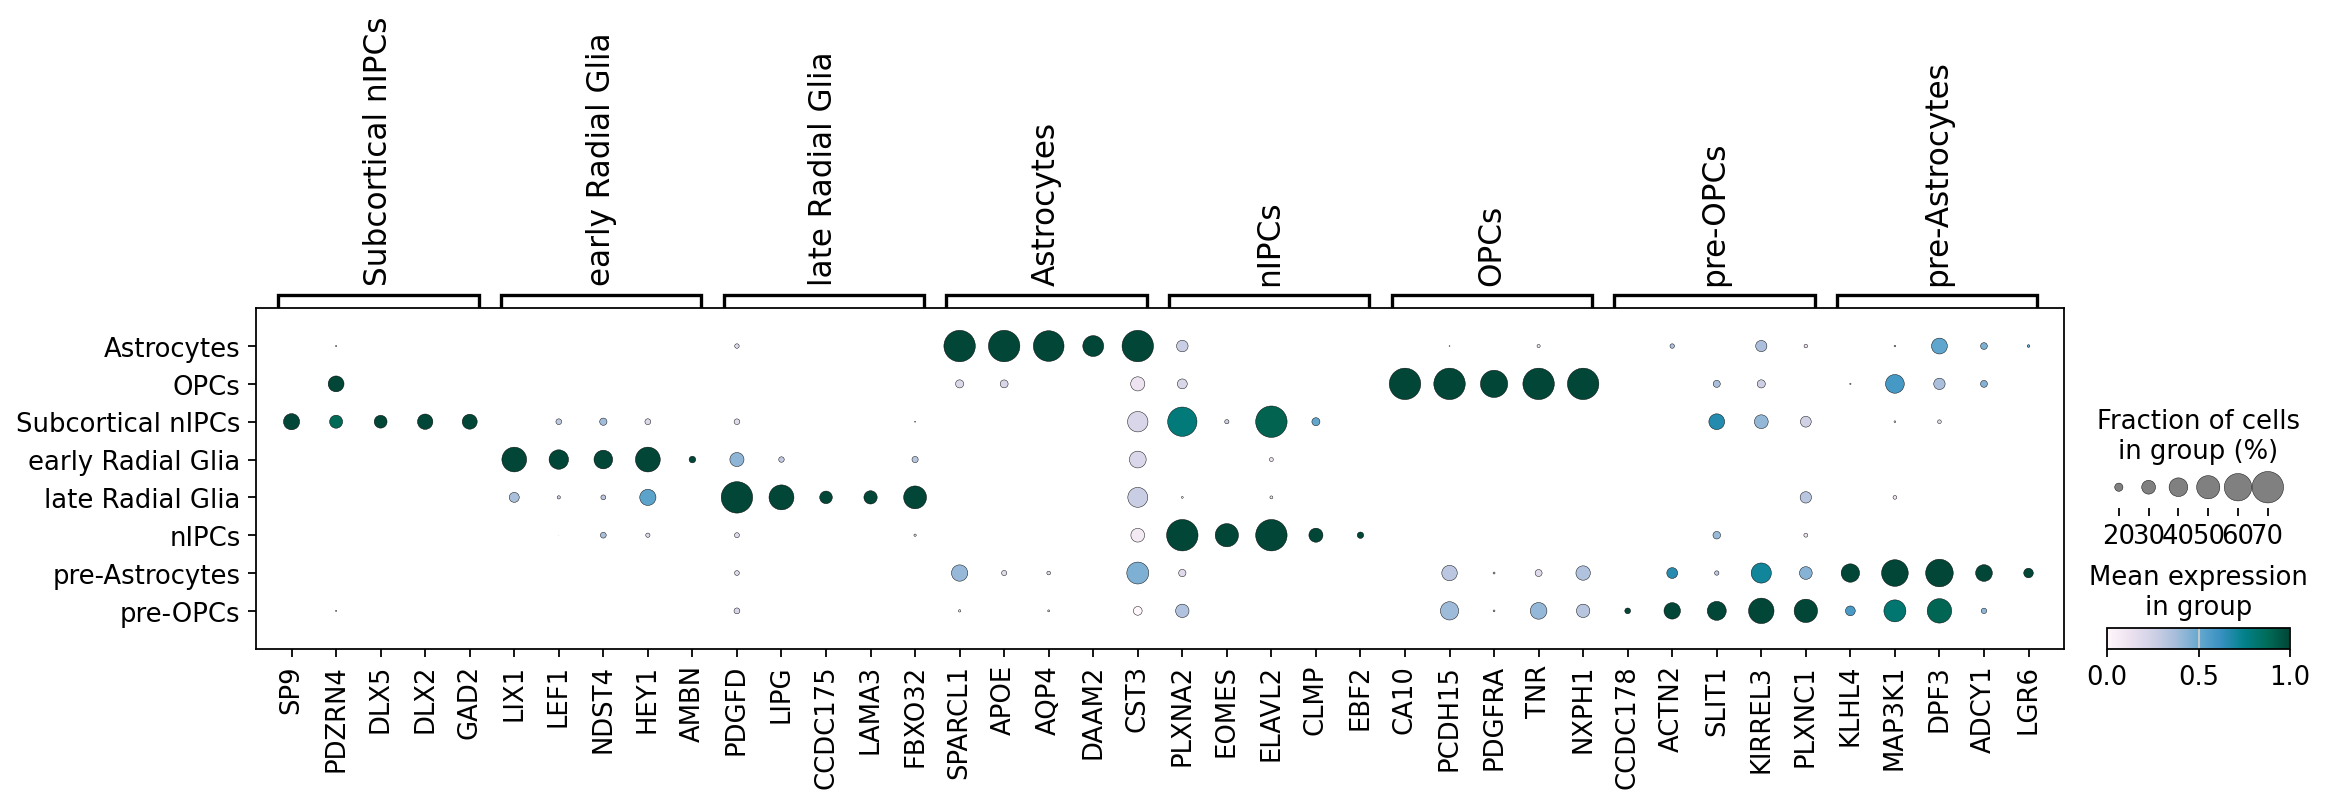

In [27]:
ax = sc.pl.dotplot(
    trainraw,
    var_names=top_five_genes,
    groupby='ThirdManualAnnotations',
    standard_scale='var',
    use_raw=False,
    color_map='PuBuGn',
    dot_max=0.7,
    dot_min=0.1,
    show=False
)

# uncomment this to save high quality figure
#plt.savefig('fig_15.png', dpi = 600)